# 2 x-modes in a periodic PIC simulation

We need to find the perturbed quantities associated with 2 x-mode waves, separated by one ion cyclotron frequency harmonic, in a periodic epoch1d simulation, and write those quantities to a file amenable to initialisation of a simulation in EPOCH.

It is necessary to fix some parameters and find others. One method is to fix the wavenumbers of the two modes and the difference in frequency. That way we can ensure that both modes fit exactly into a periodic simulation domain and the difference in their frequency will be one ion cyclotron frequency.

Hence fix $k_\alpha =n_{ka} 2\pi/L$, $k_\beta=n_{kb} 2\pi/L$, and $\omega_\beta - \omega_\alpha = \Omega_i$. 

The procedure is:
 - Fix $k_\alpha$, $k_\beta$
 - Optimise $n_e$ such that the dispersion relation is satisfied for two modes $\alpha$ and $\beta$ where $\omega_\beta = \omega_\alpha + \Omega_i$.
 - Use the nullspace, or vector associated with the singular value, of the dispersion relation matrix $\Lambda$ to obtain the electric field polarisation for each of the waves.
 - Insert the electric field into Faraday's law for the magnetic field polarisation
 - Obtain the current polarisation from the conductivity tensor, $\vec J_s = \sigma_s \cdot \vec E$
 - Obtain the velocity perturbation for each species from their currents.
 - Obtain the density perturbation for each species from the continuity equation.

The conductivity tensor $\sigma$ is defined for species $s$
$$
\sigma_s = \begin{bmatrix}
  \frac{\omega}{\omega^2 - \Omega_s^2} & \frac{i \Omega_s}{\omega^2 - \Omega_s^2} & 0\\
  -\frac{i \Omega_s}{\omega^2 - \Omega_s^2} & \frac{\omega}{\omega^2 - \Omega_s^2} & 0\\
   0 & 0 & \frac{1}{\omega} 
   \end{bmatrix} i \epsilon_0  \Pi_s^2
$$

The dielectric tensor is then $\varepsilon = I + \frac{i}{\epsilon_0 \omega} \sum_s \sigma_s$, which makes the dispersion relation tensor $\Lambda = (\vec{k} \vec{k}' - I(\vec k \cdot\vec k))\frac{c^2}{\omega^2} + \varepsilon$, for which $\vec k = |k| [\sin\theta, 0, \cos\theta]^{T}$ ($\theta=\pi/2$ corresponds to perpendicular progation studied here).

Now the other parameters:

Faraday's
$$
-i\omega\vec B_1 = - \vec k \times \vec E_1
$$
Gauss's law
$$
i\vec k \cdot \vec E_1 =  \sum_s\frac{q_s n_{s,1}}{\epsilon_0}\\
$$
Ampere's law:
$$
\mu_0 \vec J = i \vec k \times \vec {B}_1 + i \omega \mu_0 \epsilon_0 \vec E_1\\
\sum_s q_s n_{s,0} \vec {v}_{s,1} = \frac{i \vec k \times \vec {B}_1}{\mu_0} + i \omega \epsilon_0 \vec E_1\\
$$
Assume the ions are unperturbed in the initial conditions
$$
q_e n_{e,0} {v}_{e,1,y} = i  \omega \epsilon_0 E_{1,x}\\
q_e n_{e,0} {v}_{e,1,y} = -\frac{i k {B}_{1,z}}{\mu_0} + i \omega \epsilon_0 E_{1,y}\\
q_e n_{e,0} {v}_{e,1,z} = \frac{i k {B}_{1,y}}{\mu_0} + i \omega \epsilon_0 E_{1,z}\\
$$

$$
n_{e,1} = i k E_{x,1}\frac{\epsilon_0}{q_s}
$$

Continuity

$$
\omega n_{1,s} - n_{0,s} \vec k \cdot \vec v_{1,s} = 0
$$

# Appendix

Following Felix's online [notes](http://www-thphys.physics.ox.ac.uk/people/FelixParra/CollisionlessPlasmaPhysics/notes/lecV_coldplasma.pdf), find we want to find two x-modes waves, one ion cyclotron frequency apart, that both fit an integer number of wavelengths into a periodic simulation domain.

The dispersion relation $D(\omega_{choose}, k_{find})=0$ must be solved to find $k$, or conversly by fixing $k$ and finding $\omega$. In order to find a pair of waves that both fit in the box as described one must fine tune the parameters. In this notebook, I fine tune the density and keep the magnetic field fixed.

The polarisation is calculated via $\vec{\vec{D}}(\omega, k)\cdot \vec E=\vec0$ where we find the nullspace of $\vec{\vec{D}}(\omega, k)$ to give $\vec E$ and hence relative amplitudes of the components of the electric field.

For the extraordinary mode
$$
n^2=\frac{\epsilon_\bot^2-g^2}{\epsilon_\bot}\\
E_x\propto i g\\
E_y\propto -\epsilon_\bot\\
E_z = 0\\
$$
where $n=kc/\omega$
$$
\epsilon_\bot = 1- \sum_s \frac{\Pi_s^2}{\omega^2 - \Omega_s^2},\\
g = -\sum_s \frac{\Pi_s^2\Omega_s}{\omega (\omega^2 - \Omega_s^2)}
$$

In [13]:
using Roots, Plots, LinearAlgebra

const c₀ = 2.99792458e8
const ϵ₀ = 8.854187817e-12
const μ₀ = 1.25663706144e-6
const q₀ = 1.602176487e-19
const mₑ = 9.10938188e-31
const n0 = 1e19
const B0 = 2.0
fΠ(n, m::Float64=mₑ) = √(q₀^2 * n / m / ϵ₀)
const Π0 = fΠ(n0)
fΩ(m=mₑ, Z::Int=-1) = Z * q₀ * B0 / m
const Ωe = fΩ(mₑ, -1)
const mi = 1836 * mₑ * 2
const Ωi = fΩ(mi, 1)
fωL(n) = sqrt(Ωe^2 / 4 + fΠ(n)^2) + Ωe / 2
const ωL0 = fωL(n0)
fωₕ(n) = √(fΠ(n)^2 + Ωe^2)
const ωₕ0 = √(fΠ(n0)^2 + Ωe^2)
const Te_eV = 10e3
const Ti_eV = 10e3
const vth = sqrt(2 * 10e3 * q₀ / mₑ)
fλD(n) = vth / fΠ(n)
const λD0 = fλD(n0)
const fbulkenergydensity(n) = B0^2 / 2μ₀ + n * Te_eV * q₀ + n * Ti_eV * q₀

function cleaner(z)
  nz = norm(z)
  normz = z ./ nz
  normz = trunc.(real.(normz), digits=16) .+ im * trunc.(imag.(normz), digits=16)
  output = normz .* nz
  @assert output ≈ z
  return output
end

function fσ(ω, n, m=mₑ, Z=-1)
  Ωs = fΩ(m, Z) 
  Πs = fΠ(n, m)
  ω²_Ωs² = (ω^2 - Ωs^2)
  return [ω / ω²_Ωs²        im * Ωs / ω²_Ωs²  0.0; 
          -im * Ωs / ω²_Ωs²  ω / ω²_Ωs²         0.0;
          0.0               0.0                1 / ω] .* im * ϵ₀ * Πs^2
end
fϵ(ω, n) = I(3) + im * (fσ(ω, n, mₑ, -1) + fσ(ω, n, mi, 1)) / (ω * ϵ₀)
fK(k, θ=pi/2) = k * [sin(θ), 0, cos(θ)]
function fΛ(ω, k, n, θ=pi/2)
    N = fK(k, θ) * c₀ / ω
    return N * N' .- dot(N, N) * I(3) .+ fϵ(ω, n)
end
function fE(ω, k, n, θ=pi/2)
  Λ = fΛ(ω, k, n, θ)
  _, sigma, V = svd(Λ)
  @assert sigma[3] <= sqrt(eps())
  E = V[:, 3]
  @assert all(E .≈ nullspace(Λ))
  @assert all(abs.(Λ * E) .<= sqrt(eps()))
  return E
end
realdetΛ(ω, k, n=n0) = real(det(fΛ(ω, k, n)))

fB(ω, k, n) = cross([k, 0, 0], fE(ω, k, n)) / ω
fJ(ω, k, n, m::Float64, Z::Int) = fσ(ω, n, m, Z) * fE(ω, k, n)
fJ(ω, k, n) = fJ(ω, k, n, mₑ, -1) + fJ(ω, k, n, mi, 1)
fV(ω, k, n, m::Float64=mₑ, Z::Int=-1) = fJ(ω, k, n, m, Z) / q₀ / n / Z
fn(ω, k, n, m::Float64=mₑ, Z::Int=-1) = n * k * fV(ω, k, n, m, Z)[1] / ω


fn (generic function with 3 methods)

In [115]:
vthi = sqrt(Te_eV * q₀ * 2 / mi)
rli = vthi / Ωi
vthe = sqrt(Te_eV * q₀ * 2 / mₑ)
rle = vthe / abs(Ωe)

NG = 32 * 1024 
dx = min(λD0, rle) / 4
Lx = NG * dx
Kl = 2π / Lx
#Ωi = ωb - ωa
#ki = kb - ka = (nkb - nka) * Kl = δnk * Kl = 2π/rli =>  δnk = 2π/rli / Kl
@show 2π/rli / Kl
nka = 64
δnk = 1
nkb = -(nka + δnk)
ka = nka * Kl
kb = nkb * Kl
@assert ka > 0
function findn(n1)
  n1 <= 0 && return Inf
  ωa_Π0 = Roots.fzero(ω->realdetΛ(ω * Π0, ka, n1[1] * n0), 2, fatol=eps())
  ωa = ωa_Π0 * Π0
  ωtarget = ωa + Ωi
  output = realdetΛ(ωtarget, kb, n1[1] * n0)
#   @show output
  return output
end

n1 = Roots.fzero(findn, 10, xatol=1e-12)
n01 = n1 * n0
@show n1, n01, Ωe / fΠ(n01)
ωstart = fΠ(n01) * 2

ωa = Roots.fzero(ω->realdetΛ(ω * Π0, nka * Kl, n01), 2, fatol=eps()) * Π0
@assert ωa > 0
kb = nkb * Kl
ωb = ωa + Ωi
# assert that (ωa, ka) and (ωb, kb) are in fact solutions
@assert isapprox(ωa + Ωi, ωb, atol=1e-12)
@assert isapprox(ka, nka * Kl, atol=1e-12)
@assert isapprox(kb, nkb * Kl, atol=1e-12)
@assert fλD(n01) >= dx
@assert rle >= dx
@show (ωb - ωa) / Ωi
@show kb, 2π/(kb - ka) / rli
# @assert isapprox(realdetΛ(ωa, ka, n01), 0.0, atol=1e-14) "realdetΛ(ωa, ka, n01) = $(realdetΛ(ωa, ka, n01))"
# @assert isapprox(realdetΛ(ωb, kb, n01), 0.0, atol=1e-14) "realdetΛ(ωb, kb, n01) = $(realdetΛ(ωb, kb, n01))"

((2π) / rli) / Kl = 135.18814453441527
(n1, n01, Ωe / fΠ(n01)) = (25.16615165835399, 2.516615165835399e20, -0.39305334951452586)
(ωb - ωa) / Ωi = 1.0000000000003784
(kb, ((2π) / (kb - ka)) / rli) = (-295.68480138626717, -1.0479701126698857)


(-295.68480138626717, -1.0479701126698857)

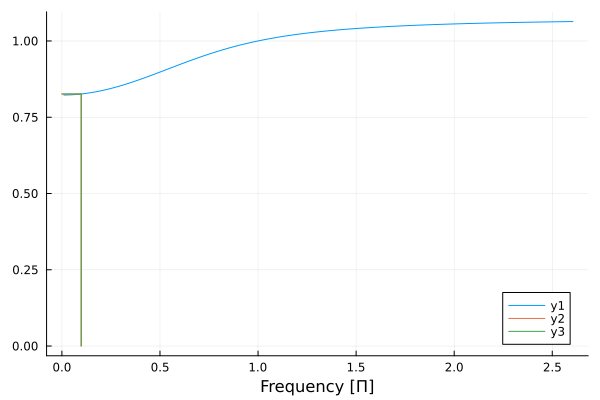

In [9]:
ωs = range(fωL(n01), stop=0.99fωₕ(n01), length=1024);
ks = [try;Roots.fzero(k->realdetΛ(ω, k, n01), 10abs(Ωe)/c₀);catch;missing;end for ω in ωs];

plot(ks .* c₀ / fΠ(n01), ωs ./ fΠ(n01))
plot!([1, 1, 0, 1] .* ka * c₀ / fΠ(n01), [0, 1, 1, 1] .* ωa / fΠ(n01))
plot!([1, 1, 0, 1] .* abs(kb) * c₀ / fΠ(n01), [0, 1, 1, 1] .* ωb / fΠ(n01))
xlabel!("Wavenumber [Π / c]")
xlabel!("Frequency [Π]")

In [15]:
function findpolarisation(ω, k, n)
  Ep = cleaner(fE(ω, k, n))
  Bp = cleaner(fB(ω, k, n))
  Jp = cleaner(fJ(ω, k, n))
  ve = cleaner(fV(ω, k, n, mₑ, -1))
  ne = cleaner(fn(ω, k, n, mₑ, -1))
  vi = cleaner(fV(ω, k, n, mi, 1))
  ni = cleaner(fn(ω, k, n, mi, 1))
  return (E=Ep, B=Bp, J=Jp, ve=ve, ne=ne, vi=vi, ni=ni)
end
pa = findpolarisation(ωa, ka, n01)
pb = findpolarisation(ωb, kb, n01)
function checkpolarisation(ω, k, polarisation)
  E = polarisation[:E]
  B = polarisation[:B]
  J = polarisation[:J]
  ve = polarisation[:ve]
  vi = polarisation[:vi]
  ne = polarisation[:ne]
  ni = polarisation[:ni]
  @assert isapprox(B[1], 0, atol=eps()) # Faraday x & no magnetic monopoles
  @assert isapprox(E[3], 0, atol=eps()) # Faraday x, polarisation of x-mode
  @assert all(ω * B ≈ cross([k, 0, 0], E)) # Faraday
  @assert ω * B[2] ≈ -k * E[3] # Faraday y, trivially zero
  @assert ω * B[3] ≈ k * E[2] # Faraday z
  @assert all(-im * J ≈ cross([k,0,0], B) / μ₀ + ω * ϵ₀ * E) # Ampere
  @assert μ₀ * J[1] ≈ im * ω * μ₀ * ϵ₀ * E[1] # Ampere x
  @assert μ₀ * J[2] ≈ - im * k * B[3] + im * ω * μ₀ * ϵ₀ * E[2] # Ampere y
  @assert isapprox(μ₀ * J[3], im * k * B[2] + im * ω * μ₀ * ϵ₀ * E[3], atol=1e-16) # Ampere z, trivially zero
  @assert im * k * E[1] * ϵ₀ ≈ q₀ * (ni - ne) # Gauss
  @assert im * k * J[1] ≈ im * q₀ * (ni - ne) * ω # divJ + drho/dt = 0 
  @assert all(J ≈ q₀ * n01 * (vi - ve)) # current
  @assert J[1] ≈ q₀ * n01 * (vi - ve)[1] # current x
  @assert J[2] ≈ q₀ * n01 * (vi - ve)[2] # current y
  @assert J[3] ≈ q₀ * n01 * (vi - ve)[3] # current z, trivially zero
end
checkpolarisation(ωa, ka, pa)
checkpolarisation(ωb, kb, pb)
@show ceil(0.01 * (2π/Ωi) / (2π/ωa))
@show pa


ceil((0.01 * ((2π) / Ωi)) / ((2π) / ωa)) = 78.0
pa = (E = ComplexF64[0.7098358741644633 - 0.0im, 0.0 - 0.7043671143297169im, 0.0 - 0.0im], B = ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 - 2.773306340586528e-10im], J = ComplexF64[0.0 + 4.647330085386634im, 4.547274299438883 + 0.0im, 0.0 + 0.0im], ve = ComplexF64[-0.0 - 0.11521341355660716im, -0.11273226339114943 - 0.0im, -0.0 - 0.0im], ne = -0.0 - 1.1416122672437937e10im, vi = ComplexF64[0.0 + 4.598706639141671e-5im, 4.563286153040223e-5 + 0.0im, 0.0 + 0.0im], ni = 0.0 + 4.556708937471231e6im)


(E = ComplexF64[0.7098358741644633 - 0.0im, 0.0 - 0.7043671143297169im, 0.0 - 0.0im], B = ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 - 2.773306340586528e-10im], J = ComplexF64[0.0 + 4.647330085386634im, 4.547274299438883 + 0.0im, 0.0 + 0.0im], ve = ComplexF64[-0.0 - 0.11521341355660716im, -0.11273226339114943 - 0.0im, -0.0 - 0.0im], ne = -0.0 - 1.1416122672437937e10im, vi = ComplexF64[0.0 + 4.598706639141671e-5im, 4.563286153040223e-5 + 0.0im, 0.0 + 0.0im], ni = 0.0 + 4.556708937471231e6im)

In [16]:
function scale(polarisation, factor::Real)
  return NamedTuple(k=>factor * v for (k, v) in pairs(polarisation))
end
function zeroions(polarisation)
  return NamedTuple(k=>!(k in (:vi, :ni)) * v for (k, v) in pairs(polarisation))
end
function energy(polarisation)
  E = polarisation[:E]
  B = polarisation[:B]
  ve = polarisation[:ve]
  vi = polarisation[:vi]
  return real(ϵ₀ * dot(E,E) / 2 + dot(B,B) / 2μ₀ +
            mₑ * n01 * dot(ve,ve) / 2 + mi * n01 * dot(vi,vi) / 2)
end
printer(polarisation, i) = printer(stdout, polarisation, i)

function printcommon(io)
  println(io, "n0 = $n01")
  println(io, "B0 = $B0")
  println(io, "Lx = $Lx")
  println(io, "NG = $NG")        
  println(io, "Te_eV = $Te_eV")
  println(io, "Ti_eV = $Ti_eV")
  println(io, "mioverme = $(round(Int, mi / mₑ))")
end
function printscalar(io, scalar, str)
  println(io, str * "_cos = $(real(scalar))")
  # Minus sign because real((a + im*b) * exp(im *k*x)) = a*cos(k*1x) - b*sin(k*x).
  println(io, str * "_sin = $(-imag(scalar))")
end
function printvector(io, vec, str)
  components = ["x", "y", "z"]
  for i in 1:3
    printscalar(io, vec[i], str * components[i])
  end
end

function printer(io, polarisation, i)
  printvector(io, polarisation[:E], "E$(i)")
  printvector(io, polarisation[:B], "B$(i)")
  printvector(io, polarisation[:J], "J$(i)")
  printvector(io, polarisation[:ve] * mₑ, "Pe$(i)")
  printvector(io, polarisation[:vi] * mi, "Pi$(i)")
  printscalar(io, polarisation[:ne], "ne$(i)x")
  printscalar(io, polarisation[:ni], "ni$(i)x")
end
bulkenergydensity = fbulkenergydensity(n01)
energyratio = 1e-2
pb = scale(pb, sqrt(energy(pa) / energy(pb)))
@assert energy(pa) ≈ energy(pb)
pa = scale(pa, sqrt(bulkenergydensity * energyratio / energy(pa)))
pb = scale(pb, sqrt(bulkenergydensity * energyratio / energy(pb)))
@assert energy(pa) ≈ energyratio * bulkenergydensity
@assert energy(pb) ≈ energyratio * bulkenergydensity
checkpolarisation(ωa, ka, pa) # make sure they're still consitent
checkpolarisation(ωb, kb, pb) # make sure they're still consitent

open("null.prefix.deck","w") do io
  println(io, "begin:constant")
  printcommon(io)
  println(io, "# Wave A")
  println(io, "w1 = $ωa")
  println(io, "k1 = $ka")
  printer(io, scale(pa, 0), 1)
  println(io, "# Wave B")
  println(io, "w2 = $ωb")
  println(io, "k2 = $kb")
  printer(io, scale(pb, 0), 2)
end

open("wave1.prefix.deck","w") do io
  println(io, "begin:constant")
  printcommon(io)
  println(io, "# Wave A")
  println(io, "w1 = $ωa")
  println(io, "k1 = $ka")
  printer(io, pa, 1)
  println(io, "# Wave B")
  println(io, "w2 = $ωb")
  println(io, "k2 = $kb")
  printer(io, scale(pb, 0), 2)
end

open("wave2.prefix.deck","w") do io
  println(io, "begin:constant")
  printcommon(io)
  println(io, "# Wave A")
  println(io, "w1 = $ωa")
  println(io, "k1 = $ka")
  printer(io, scale(pa, 0), 1)
  println(io, "# Wave B")
  println(io, "w2 = $ωb")
  println(io, "k2 = $kb")
  printer(io, pb, 2)
end

open("both.prefix.deck","w") do io
  println(io, "begin:constant")
  printcommon(io)
  println(io, "# Wave A")
  println(io, "w1 = $ωa")
  println(io, "k1 = $ka")
  printer(io, pa, 1)
  println(io, "# Wave B")
  println(io, "w2 = $ωb")
  println(io, "k2 = $kb")
  printer(io, pb, 2)
end
